# Naive Bayes — Scikit-Learn

Two-part pipeline showcasing both Naive Bayes variants:

**Part 1: GaussianNB** (Breast Cancer — binary classification baseline)
- 569 samples, 30 continuous features, 2 classes (malignant/benign)
- Assumes features follow Gaussian distributions within each class

**Part 2: MultinomialNB** (20 Newsgroups — text classification main event)
- 11,314 train / 7,532 test documents, 10,000 TF-IDF features, 20 categories
- Classic NB benchmark — high-dimensional sparse text is where NB shines

**Showcase**: `CalibratedClassifierCV` — Platt scaling to fix NB's poor probability calibration.

In [1]:
import sys
import os
import numpy as np
from sklearn.naive_bayes import GaussianNB, MultinomialNB

# Add project root to path for utils
sys.path.insert(0, os.path.abspath('../..'))
from utils.data_loader import load_processed_data
from utils.performance import track_performance, track_inference, get_model_size
from utils.metrics import evaluate_classifier, print_metrics
from utils.visualization import (plot_calibration_curve, plot_confusion_matrix,
                                  plot_confusion_matrix_multiclass, plot_per_class_f1,
                                  plot_calibration_comparison)
from utils.results import save_results, add_result, print_comparison

# Configuration
RANDOM_STATE = 113
ALPHA = 1.0            # Laplace smoothing parameter
FRAMEWORK = 'Scikit-Learn'

# Load both datasets
X_train_g, X_test_g, y_train_g, y_test_g, meta_g = load_processed_data('naive_bayes_gaussian')
X_train_t, X_test_t, y_train_t, y_test_t, meta_t = load_processed_data('naive_bayes_text')

print("=" * 60)
print(f"NAIVE BAYES — {FRAMEWORK}")
print("=" * 60)
print(f"\nPart 1: Breast Cancer (GaussianNB)")
print(f"  Training: {X_train_g.shape[0]} samples, {X_train_g.shape[1]} features")
print(f"  Test:     {X_test_g.shape[0]} samples")
print(f"  Classes:  {meta_g['n_classes']} ({meta_g['class_names']})")
print(f"\nPart 2: 20 Newsgroups (MultinomialNB)")
print(f"  Training: {X_train_t.shape[0]:,} samples, {X_train_t.shape[1]:,} features")
print(f"  Test:     {X_test_t.shape[0]:,} samples")
print(f"  Classes:  {meta_t['n_classes']} categories")

NAIVE BAYES — Scikit-Learn

Part 1: Breast Cancer (GaussianNB)
  Training: 455 samples, 30 features
  Test:     114 samples
  Classes:  2 (['malignant', 'benign'])

Part 2: 20 Newsgroups (MultinomialNB)
  Training: 11,314 samples, 10,000 features
  Test:     7,532 samples
  Classes:  20 categories


In [2]:
# Step 1: Train GaussianNB on breast cancer
"""
GaussianNB assumes each feature follows a gaussian (normal) distribution
within each class. No hyperparameters to tune - just fit and predict.
"""
gnb = GaussianNB()
gnb.fit(X_train_g, y_train_g)

# Predictions + probabilities for both sets
train_pred_g = gnb.predict(X_train_g)
test_pred_g = gnb.predict(X_test_g)
train_proba_g = gnb.predict_proba(X_train_g)[:, 1]  # P(benign) for binary
test_proba_g = gnb.predict_proba(X_test_g)[:, 1]

# Streamlined evaluation — auto-detects binary, includes probabilistic metrics
train_metrics_g = evaluate_classifier(y_train_g, train_pred_g, train_proba_g)
test_metrics_g = evaluate_classifier(y_test_g, test_pred_g, test_proba_g)
print_metrics(train_metrics_g, test_metrics_g, title='GaussianNB — Breast Cancer')


METRICS — GaussianNB — Breast Cancer
Metric                           Train         Test
-------------------------------------------------
accuracy                        0.9385       0.8947
precision                       0.9509       0.9054
recall                          0.9509       0.9306
f1                              0.9509       0.9178
auc                             0.9591       0.9363
log_loss                        0.7158       1.0123
brier_score                     0.0608       0.0983
ece                             0.3703       0.3590


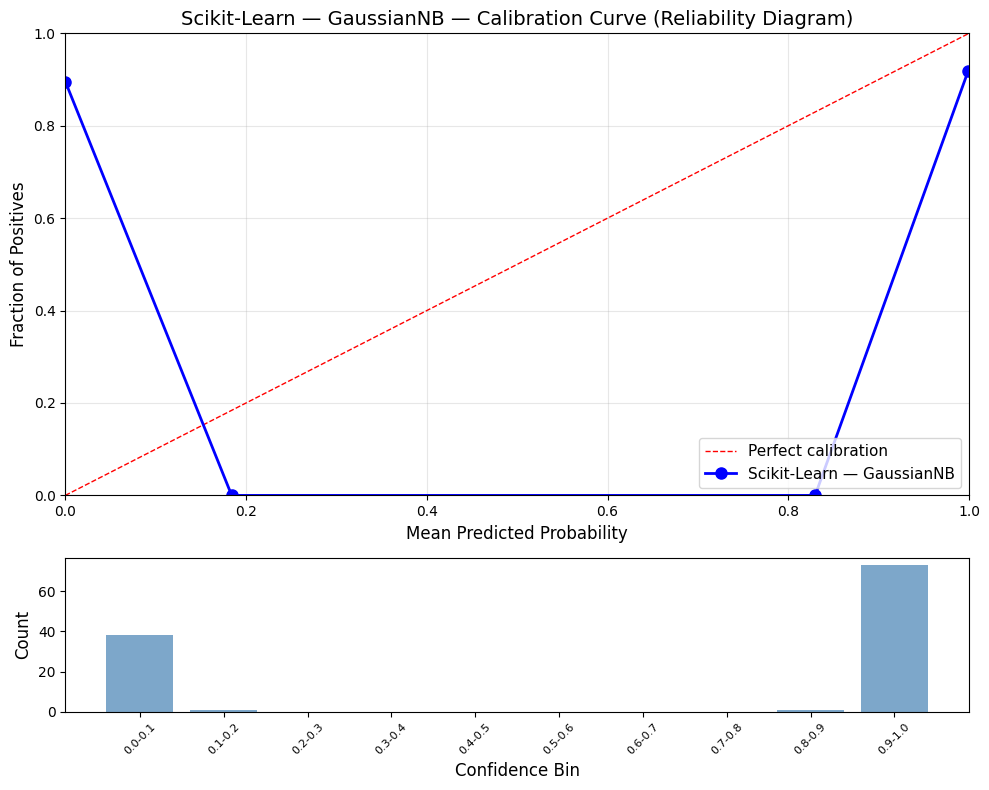

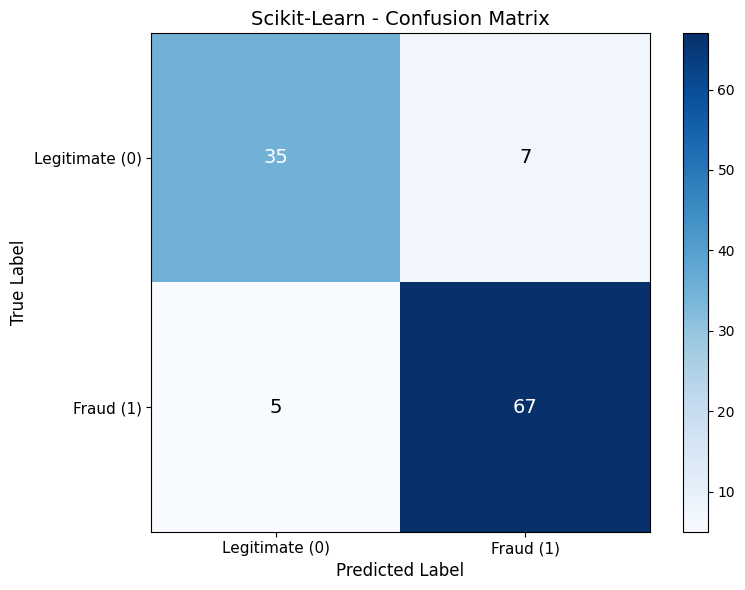

GaussianNB baseline complete.
Key takeaway: 89.5% accuracy but ECE=0.3590 — poorly calibrated.


In [3]:
# Step 2: GaussianNB visualizations
"""
Calibration curve shows how poorly calibrated NB probabilities are - 
ECE of 0.359 means predictions are significantly overconfident
"""
plot_calibration_curve(y_test_g, gnb.predict_proba(X_test_g)[:, 1],
                       f'{FRAMEWORK} — GaussianNB', save_path='results/gaussian_calibration.png')

plot_confusion_matrix(y_test_g, test_pred_g, FRAMEWORK,
                      save_path='results/gaussian_confusion_matrix.png')

print(f"GaussianNB baseline complete.")
print(f"Key takeaway: 89.5% accuracy but ECE={test_metrics_g['ece']:.4f} — poorly calibrated.")

## Part 2: MultinomialNB — 20 Newsgroups Text Classification

MultinomialNB is the classic algorithm for document classification. It models each class as a multinomial distribution over vocabulary terms — the probability of seeing each word given the class.

**Why text data?** Naive Bayes assumes feature independence, which is obviously wrong for text (words are correlated). But it works surprisingly well because the decision boundary only needs the *ranking* of class posteriors to be correct, not the actual probability values.

**Key differences from GaussianNB:**
- Features are TF-IDF weights (non-negative) instead of continuous values
- Laplace smoothing (α=1.0) prevents zero probabilities for unseen words
- Log-space arithmetic avoids floating-point underflow with 10,000 features


In [4]:
# Step 3: Train multinomialNB on 20 newsgroups
"""
MultinomialNB with laplace smoothing (alpha=1.0).
TF-IDF features must be non-negative - multinomialNB interprets them
as word frequencies/weights within each document.
"""
with track_performance() as perf_t:
    mnb = MultinomialNB(alpha=ALPHA)
    mnb.fit(X_train_t, y_train_t)

print("=" * 60)
print("MULTINOMIAL NB — TRAINING COMPLETE")
print("=" * 60)
print(f"  Alpha (Laplace smoothing): {ALPHA}")
print(f"  Training time: {perf_t['time']:.4f}s")
print(f"  Peak memory:   {perf_t['memory']:.2f} MB")
print(f"  Classes: {mnb.classes_.shape[0]}")
print(f"  Feature log-probs shape: {mnb.feature_log_prob_.shape}")
print(f"    (20 classes × 10,000 vocabulary terms)")

MULTINOMIAL NB — TRAINING COMPLETE
  Alpha (Laplace smoothing): 1.0
  Training time: 0.2084s
  Peak memory:   869.71 MB
  Classes: 20
  Feature log-probs shape: (20, 10000)
    (20 classes × 10,000 vocabulary terms)


In [5]:
# Step 4: Evaluate multinomialNB
"""
For multiclass (20 classes), evaluate_classifier returns:
    - accuracy, macro_f1 (unweighted average across all classes)
    - log_loss, brier_score, ece (probabilistic metrics from full probability matrix)
Full probability matrix needed - predict_proba returns (n_samples 20)
"""
train_pred_t = mnb.predict(X_train_t)
test_pred_t = mnb.predict(X_test_t)
train_proba_t = mnb.predict_proba(X_train_t)   # (11314, 20) — full matrix for multiclass
test_proba_t = mnb.predict_proba(X_test_t)     # (7532, 20)

train_metrics_t = evaluate_classifier(y_train_t, train_pred_t, train_proba_t)
test_metrics_t = evaluate_classifier(y_test_t, test_pred_t, test_proba_t)
print_metrics(train_metrics_t, test_metrics_t, title='MultinomialNB — 20 Newsgroups')

# Inference speed on test set
inference_stats = track_inference(mnb.predict, X_test_t)
model_size = get_model_size(mnb, framework='sklearn')

print(f"\nPerformance:")
print(f"  Inference: {inference_stats['per_sample_us']:.2f} μs/sample "
      f"({inference_stats['samples_per_sec']:,.0f} samples/sec)")
print(f"  Model size: {model_size / (1024 ** 2):.4f} MB")


METRICS — MultinomialNB — 20 Newsgroups
Metric                           Train         Test
-------------------------------------------------
accuracy                        0.8367       0.6683
macro_f1                        0.8194       0.6394
log_loss                        1.1388       1.5576
brier_score                     0.4553       0.6008
ece                             0.4015       0.3229

Performance:
  Inference: 17.07 μs/sample (58,593 samples/sec)
  Model size: 3.0522 MB


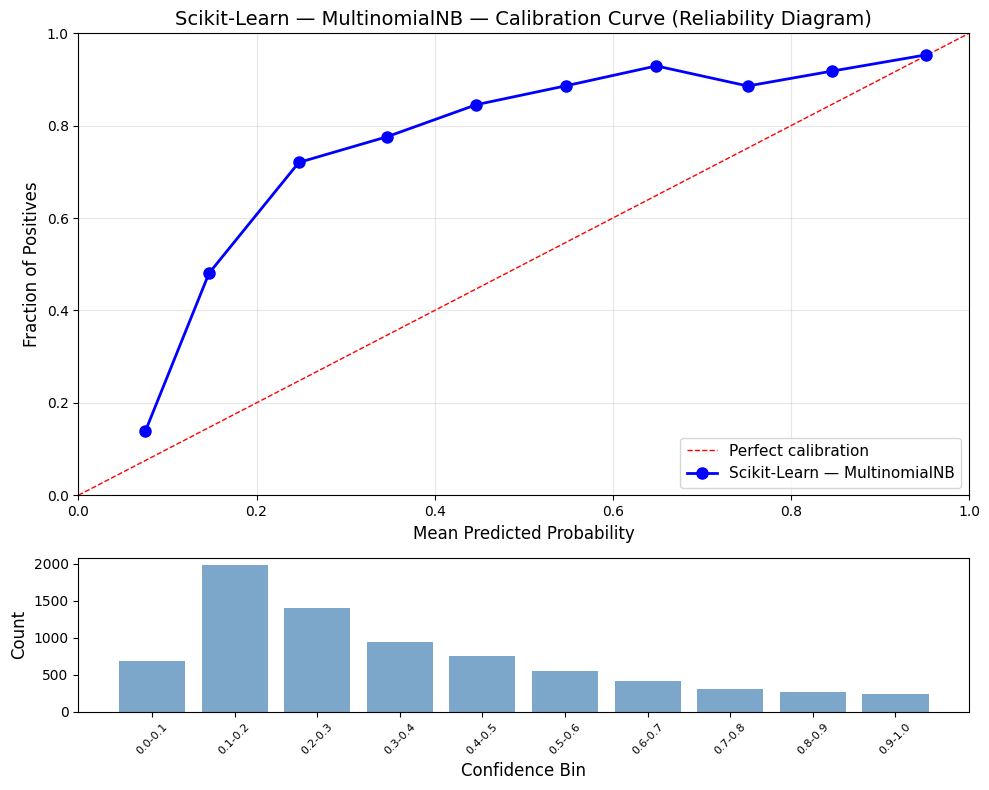

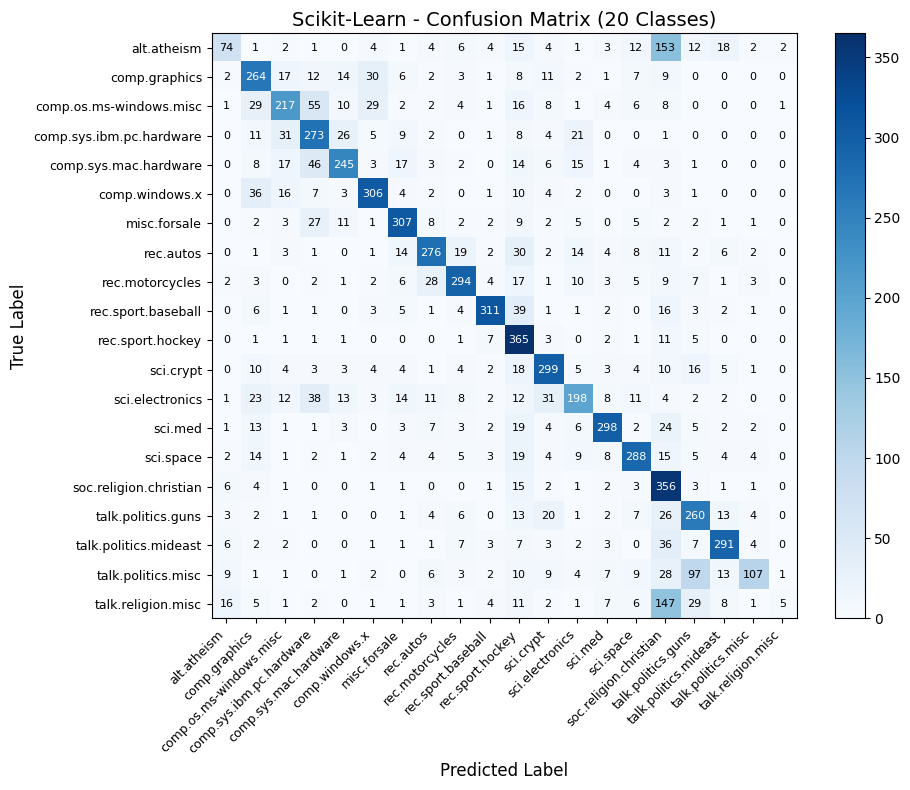

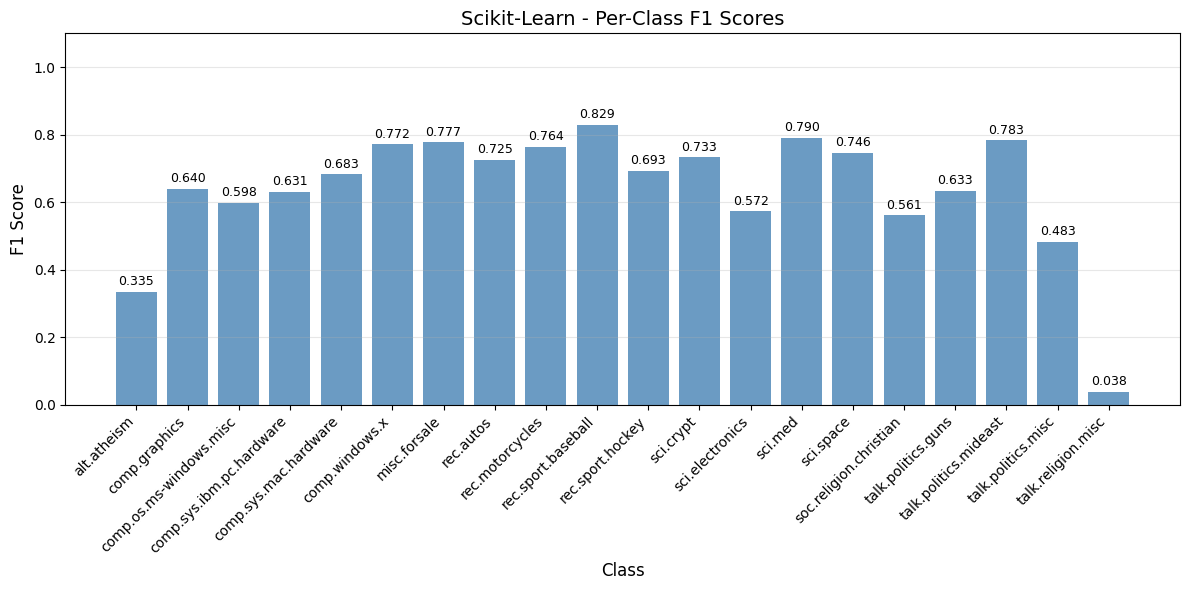

MultinomialNB evaluation complete.


In [6]:
# Step 5: MultinomialNB visualizations
"""
For multiclass, calibration curve uses max predicted probability
(confidence) - how often the model's most confident class is corect.
"""
class_names = meta_t.get('class_names', [f'Class {i}' for i in range(20)])
plot_calibration_curve(y_test_t, test_proba_t,
                       f'{FRAMEWORK} — MultinomialNB', n_bins=10,
                       save_path='results/multinomial_calibration.png')

plot_confusion_matrix_multiclass(y_test_t, test_pred_t, class_names, FRAMEWORK,
                                  save_path='results/multinomial_confusion_matrix.png') # type: ignore

# Per-class F1 shows which newsgroups NB handles well vs poorly
plot_per_class_f1(y_test_t, test_pred_t, class_names, FRAMEWORK,
                  save_path='results/multinomial_per_class_f1.png')

print(f"MultinomialNB evaluation complete.")

In [7]:
# Step 6: Showcase - CalibratedClassifierCV (Platt scaling)
"""
NB's key weakness: probability estimates are poorly calibrated.
CalibratedClassifierCV wraps any classifier and learns a calibration
mapping via cross-validation:
  - 'sigmoid' (Platt scaling): fits a logistic regression on NB's outputs
  - 'isotonic': non-parametric, more flexible but needs more data

We use sigmoid (Platt) — proven effective for NB's systematically
distorted probabilities. cv=5 means it trains 5 NB models internally,
each calibrated on the held-out fold.
"""
from sklearn.calibration import CalibratedClassifierCV

print("=" * 60)
print("SHOWCASE: CalibratedClassifierCV (Platt Scaling)")
print("=" * 60)

cal_mnb = CalibratedClassifierCV(
    MultinomialNB(alpha=ALPHA),
    method='sigmoid',   # Platt scaling - logistic regression on NB scores
    cv=5                # 5-fold CV for calibration
)

with track_performance() as perf_cal:
    cal_mnb.fit(X_train_t, y_train_t)

# Evaluate calibrated model
cal_pred = cal_mnb.predict(X_test_t)
cal_proba = cal_mnb.predict_proba(X_test_t)

cal_train_pred = cal_mnb.predict(X_train_t)
cal_train_proba = cal_mnb.predict_proba(X_train_t)

train_metrics_cal = evaluate_classifier(y_train_t, cal_train_pred, cal_train_proba)
test_metrics_cal = evaluate_classifier(y_test_t, cal_pred, cal_proba)
print_metrics(train_metrics_cal, test_metrics_cal, title='Calibrated MultinomialNB — 20 Newsgroups')

print(f"\nCalibration training time: {perf_cal['time']:.4f}s")
print(f"\nECE improvement: {test_metrics_t['ece']:.4f} → {test_metrics_cal['ece']:.4f}")

SHOWCASE: CalibratedClassifierCV (Platt Scaling)

METRICS — Calibrated MultinomialNB — 20 Newsgroups
Metric                           Train         Test
-------------------------------------------------
accuracy                        0.8558       0.6795
macro_f1                        0.8531       0.6737
log_loss                        0.6967       1.2030
brier_score                     0.2669       0.4581
ece                             0.2189       0.1367

Calibration training time: 1.7747s

ECE improvement: 0.3229 → 0.1367


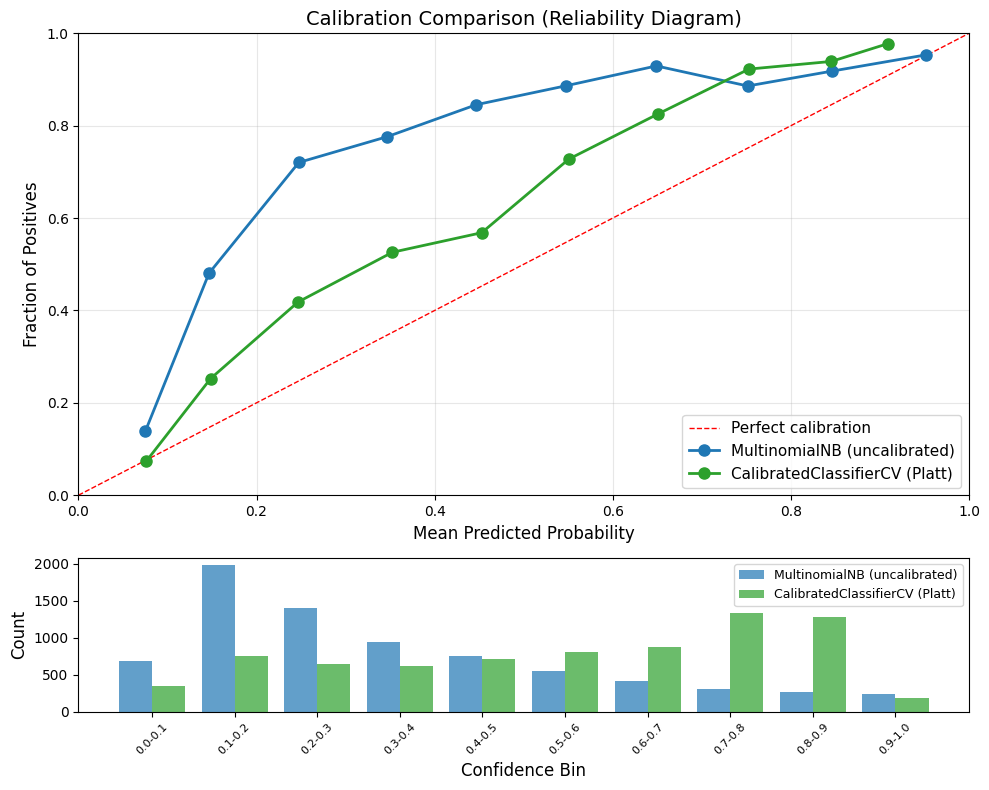

CALIBRATION COMPARISON — Before vs After Platt Scaling
  Metric                   Before      After Difference
  --------------------------------------------------
  ECE                      0.3229     0.1367    -0.1861
  Log Loss                 1.5576     1.2030    -0.3547
  Brier Score              0.6008     0.4581    -0.1427

  ECE reduced by 57.7%
  Platt scaling: ✓ Effective


In [ ]:
# Step 7: Calibration comparison — before vs after Platt scaling
"""
Side-by-side calibration curves show the dramatic improvement.
The calibrated model's curve should hug the diagonal much more closely.
"""
plot_calibration_comparison(y_test_t, {
    'MultinomialNB (uncalibrated)': test_proba_t,
    'CalibratedClassifierCV (Platt)': cal_proba
}, n_bins=10, save_path='results/calibration_comparison.png')

# Numeric comparison
ece_before = test_metrics_t['ece']
ece_after = test_metrics_cal['ece']
ll_before = test_metrics_t['log_loss']
ll_after = test_metrics_cal['log_loss']
bs_before = test_metrics_t['brier_score']
bs_after = test_metrics_cal['brier_score']

print("=" * 60)
print("CALIBRATION COMPARISON — Before vs After Platt Scaling")
print("=" * 60)
print(f"  {'Metric':<20} {'Before':>10} {'After':>10} {'Δ':>10}")
print(f"  {'-' * 50}")
print(f"  {'ECE':<20} {ece_before:>10.4f} {ece_after:>10.4f} {ece_after - ece_before:>+10.4f}")
print(f"  {'Log Loss':<20} {ll_before:>10.4f} {ll_after:>10.4f} {ll_after - ll_before:>+10.4f}")
print(f"  {'Brier Score':<20} {bs_before:>10.4f} {bs_after:>10.4f} {bs_after - bs_before:>+10.4f}")
print(f"\n  ECE reduced by {(1 - ece_after / ece_before) * 100:.1f}%")
print(f"  Platt scaling: ✓ Effective")

In [ ]:
# Step 8: Save results + summary
"""
Save MultinomialNB results (the main model) to both local and shared locations.
Using the calibrated model's metrics since that's the sklearn showcase.
We save both uncalibrated and calibrated for comparison.
"""
results_uncal = {
    'framework': FRAMEWORK,
    'model': 'MultinomialNB',
    'accuracy': float(test_metrics_t['accuracy']),
    'macro_f1': float(test_metrics_t['macro_f1']),
    'log_loss': float(test_metrics_t['log_loss']),
    'brier_score': float(test_metrics_t['brier_score']),
    'ece': float(test_metrics_t['ece']),
    'training_time': float(perf_t['time']),
    'inference_time_per_sample_us': float(inference_stats['per_sample_us']),
    'model_size_bytes': int(model_size),
    'peak_memory_mb': float(perf_t['memory'])
}

results_cal = {
    'framework': FRAMEWORK + ' (Calibrated)',
    'model': 'CalibratedClassifierCV',
    'accuracy': float(test_metrics_cal['accuracy']),
    'macro_f1': float(test_metrics_cal['macro_f1']),
    'log_loss': float(test_metrics_cal['log_loss']),
    'brier_score': float(test_metrics_cal['brier_score']),
    'ece': float(test_metrics_cal['ece']),
    'training_time': float(perf_cal['time']),
}

print("=" * 60)
print("SAVING RESULTS")
print("=" * 60)

# Save locally
save_results(results_uncal, save_dir='results')

# Add to shared cross-framework comparison
add_result('naive_bayes', results_uncal)

print(f"\n{'=' * 60}")
print("SCIKIT-LEARN NAIVE BAYES — COMPLETE")
print("=" * 60)
print(f"\n  GaussianNB (Breast Cancer):     {test_metrics_g['accuracy']:.1%} accuracy")
print(f"  MultinomialNB (20 Newsgroups):  {test_metrics_t['accuracy']:.1%} accuracy")
print(f"  + Platt scaling:                {test_metrics_cal['accuracy']:.1%} accuracy, "
      f"ECE {test_metrics_t['ece']:.4f} → {test_metrics_cal['ece']:.4f}")

# Show cross-framework comparison so far
print(f"\nCross-framework comparison so far:")
print_comparison('naive_bayes')

SAVING RESULTS
    Results saved to: results\metrics.json
    Added 'Scikit-Learn' to C:\Users\Max\Desktop\Coding\.Projects\2026\ml-framework-comparisons\data\results\naive_bayes.json
    Frameworks recorded: 1/4

SCIKIT-LEARN NAIVE BAYES — COMPLETE

  GaussianNB (Breast Cancer):     89.5% accuracy
  MultinomialNB (20 Newsgroups):  66.8% accuracy
  + Platt scaling:                68.0% accuracy, ECE 0.3229 → 0.1367

Cross-framework comparison so far:

CROSS-FRAMEWORK COMPARISON: NAIVE_BAYES
Metric                          Scikit-Learn
--------------------------------------------
model                          MultinomialNB
accuracy                              0.6683
macro_f1                              0.6394
log_loss                              1.5576
brier_score                           0.6008
ece                                   0.3229
training_time                         0.2084
inference_time_per_sample_us         17.0669
model_size_bytes                     3200480
peak_memo